# Возраст подписчиков разных групп/людей в VK

In [1]:
import time
import os
from time import sleep

import numpy as np
import pandas as pd
from tqdm import tqdm

import vk
from lazy import lazy

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (16, 9)
rcParams['figure.max_open_warning'] = 100

In [3]:
def make_dir_fn(filename):
    dir_name = ('./'+filename).rsplit('/', 1)[0]
    try:
        os.makedirs(dir_name)
    except:
        pass

In [4]:
class ParseAge:
    @lazy
    def _current_time(self):
        return time.localtime()

    def __call__(self, date_string):
        try:
            d, m, y = [int(t) for t in date_string.split('.')]
            if m>12 or m<1 or d>31 or d<1:
                return None
            r = self._current_time.tm_year - y
            if m>self._current_time.tm_mon or (m==self._current_time.tm_mon and d>=self._current_time.tm_mday):
                r += 1
            return r
        except:
            return None

In [5]:
class PeopleInfoParser:
    def __init__(self, tkn, fields=None, verbose=True):
        self._tkn = tkn
        self._fields = fields if fields is not None else 'bdate,sex,city'
        self.verbose = verbose
        self._delay = 0.3
        self._delay_after_error = 5
        self._max_age = 70

    @lazy
    def api(self):
        session = vk.Session(access_token=self._tkn)
        return vk.API(session)
    
    @lazy
    def _parse_age(self):
        return ParseAge()
    
    def _get_followers(self, user_id, offset=0):
        return self.api.users.getFollowers(user_id=user_id, offset=offset, fields=self._fields, count=1000)

    def _get_df(self, people_info, filename=None):
        df = pd.DataFrame(people_info)
        if 'bdate' in df.columns:
            df['age'] = df.bdate.apply(self._parse_age)
        if 'sex' in df.columns:
            df['sex'] = df.sex.map({0: None, 1:u'Ж', 2:u'М'})
        if filename:
            make_dir_fn(filename)
            df.to_pickle(filename)
        return df
    
    def _get_group_members_list(self, group_id):
        group_info = self.api.groups.getById(group_id=group_id, fields = 'members_count')[0]
        iterations_num = int(group_info['members_count'] / 1000) + 1
        
        members = []
        for i in tqdm(range(iterations_num)):
            try:
                members += self.api.groups.getMembers(group_id=group_id, offset=i*1000)['users']
            except:
                if self.verbose:
                    print('..error occured, taking {} sec pause'.format(self._delay_after_error))
                sleep(self._delay_after_error)
                try:
                    members += self.api.groups.getMembers(group_id=group_id, offset=i*1000)['users']
                except:
                    if self.verbose:
                        print('failed on {} iteration'.format(i))
                    return None
            sleep(self._delay)
        return members

    def _get_user_ids_df(self, users_ids_list, filename=None):
        iterations_num = int(len(users_ids_list) / 1000) + 1
        members_info = []
        for i in tqdm(range(iterations_num)):
            user_ids = users_ids_list[(i*1000):((i+1)*1000)]
            try:
                members_info +=self.api.users.get(user_ids=user_ids, fields=self._fields)
            except:
                if self.verbose:
                    print('..error occured, taking {} sec pause'.format(self._delay_after_error))
                sleep(self._delay_after_error)
                try:
                    members_info +=self.api.users.get(user_ids=user_ids, fields=self._fields)
                except:
                    if self.verbose:
                        print('failed on {} iteration'.format(i))
                    return self._get_df(members_info, filename)
            sleep(self._delay)
        return self._get_df(members_info, filename)

    def get_members_df(self, group_id, filename=None):
        members = self._get_group_members_list(group_id)
        return self._get_user_ids_df(members, filename)
        
    def get_followers_df(self, user_id, filename=None):
        t = self._get_followers(user_id)
        followers_number = t['count']
        followers = t['items']
        iterations_num = int(followers_number / 1000) + 1
        for i in tqdm(range(1, iterations_num)):
            try:
                followers += self._get_followers(user_id, i*1000)['items']
            except:
                if self.verbose:
                    print('..error occured, taking {} sec pause'.format(self._delay_after_error))
                sleep(self._delay_after_error)
                try:
                    followers += self._get_followers(user_id, i*1000)['items']
                except:
                    if self.verbose:
                        print('failed on {} iteration'.format(i))
                    return self._get_df(followers, filename)
            sleep(self._delay)
        return self._get_df(followers, filename)

    def get_df(self, user_id=None, group_id=None, filename=None):
        if user_id and group_id or user_id is None and group_id is None:
            raise "Set user_id or group_id"
        if user_id:
            return self.get_followers_df(user_id, filename)
        if group_id:
            return self.get_members_df(group_id, filename)

    def get_stat(self, df, whose=None, kde=False, hist=True, new_plot=True, sex_separately=True):
        sex_stat = df.sex.value_counts(normalize=True)*100
        whose = " "+whose if whose else ""
        title = u'Подписчики{}. М/Ж: {:.0f}/{:.0f}. Медианный возраст Общий, М, Ж: {:.0f}, {:.0f}, {:.0f}'
        params = (
            whose,
            sex_stat[u'М'],
            sex_stat[u'Ж'],
            df.age.median(), 
            df[df.sex==u'М'].age.median(),
            df[df.sex==u'Ж'].age.median()
        )
        sdf = df[df.age<=self._max_age]

        if new_plot:
            plt.figure()
        bins = int(sdf.age.max()-sdf.age.min()+1)
        if sex_separately:
            sns.distplot(sdf[sdf.sex==u'М'].age, kde=kde, hist=hist, label=u'М', color='blue', bins=bins)
            sns.distplot(sdf[sdf.sex==u'Ж'].age, kde=kde, hist=hist, label=u'Ж', color='red', bins=bins)
        else:
            sns.distplot(sdf.age, kde=kde, hist=hist, label=whose+" - "+str(int(df.age.median())), bins=bins)
        plt.title(title.format(*params))

In [6]:
class SpecParser:
    def __init__(self, tkn, fields=None, verbose=True):
        self.parser = PeopleInfoParser(tkn, fields=fields, verbose=verbose)
        self.verbose = verbose
    
    def _augment_spec(self, spec, folder=None):
        try:
            os.makedirs(folder)
        except:
            pass
        
        if not folder.endswith('/') and folder:
            folder += "/"
        for s in spec:
            s["filename"] = s.get("filename") or "{}{}.pkl".format(folder, s["titlename"])
            s["titlename"] = s.get("titlename") or s["filename"].split('.')[-2].split('/')[-1]
            s["topic"] = s.get("topic") or "general"
        return spec
    
    def _read_pkl(self, spec_obj):
        try:
            return pd.read_pickle(spec_obj["filename"])
        except: 
            return None
        
    def _download_pkl(self, spec_obj):
        if self.verbose:
            print('..downloading {}'.format(spec_obj["filename"]))
        return self.parser.get_df(
            user_id = spec_obj.get("uid"),
            group_id = spec_obj.get("gid"),
            filename = spec_obj.get("filename")
        )

    def __call__(self, spec, folder=None, plot=True, agg_df=False):
        spec = self._augment_spec(spec, folder)
        if agg_df:
            dfs = []
        for s in spec:
            df = self._read_pkl(s)
            if df is None:
                df = self._download_pkl(s)
            if agg_df:
                dfs.append(df)
            if plot:
                self.parser.get_stat(df=df, whose=s["titlename"], kde=False, hist=True)
        if agg_df:
            return dfs
    
    def make_join_dist_plot(self, spec, folder=None):
        spec = self._augment_spec(spec, folder)
        dfs = []
        for s in spec:
            df = pd.read_pickle(s["filename"])
            self.parser.get_stat(df, whose=s["titlename"], kde=True, hist=False, sex_separately=False, new_plot=False)
        plt.title("Возраст подписчиков")

-----

## Настройка

##### Получение токена

Вставить свои логин-пароль от вк в url ниже, перейти по адресу в браузере, скопировать из перенаправленного url'а токен. Profit.

https://oauth.vk.com/token?grant_type=password&scope=audio&client_id=2274003&client_secret=hHbZxrka2uZ6jB1inYsH&username=&password=

##### Получение user_id / group_id

открыть любой пост и скопировать оттуда первый id

In [7]:
tkn = 'получите_токен_выше'

In [8]:
folder = 'data/'

In [9]:
spec = [
    {"gid": 12908334, "titlename": "Каца", "topic": "politics"},
    {"uid": 309659217, "titlename":"Гудкова", "topic": "politics"},
    {"uid": 129244038, "titlename": "Навального", "topic": "politics"},
    {"uid": 3686745, "titlename": "Яшина", "topic": "politics"},
    {"gid": 47609669, "titlename": "Шлосберга", "topic": "politics"},
    {"uid": 241575572, "titlename": "Ходорковского", "topic": "politics"},
    
    {"gid": 63575, "titlename": "Яблока", "topic": "political_party"},
    {"gid": 433349, "titlename": "ЛДПР", "topic": "political_party"},
    {"gid": 26362316, "titlename": "КПРФ", "topic": "political_party"},
    {"gid": 113757409, "titlename": "Справедливой России", "topic": "political_party"},
    {"gid": 18483909, "titlename": "Единой России", "topic": "political_party"},

    {"gid": 2028, "titlename": "5nizza", "topic": "music"},
    {"gid": 2251, "titlename": "Lumen", "topic": "music"},
    {"gid": 9525, "titlename": "Касты", "topic": "music"},
    {"gid": 77521, "titlename": "Noize MC", "topic": "music"},
    {"gid": 3113588, "titlename": "Oxxymiron", "topic": "music"},
    {"uid": 92442688, "titlename": "Дмитрия Маликова", "topic": "music"},
    {"gid": 16595732, "titlename": "Алоэвера", "topic": "music"},
    {"gid": 417893, "titlename": "Alai Oli", "topic": "music"},
    {"gid": 23408047, "titlename": "Земфира", "topic": "music"},
    {"gid": 14675331, "titlename": "Therr Maitz", "topic": "music"},
    {"gid": 19308134, "titlename": "Ивана Дорна", "topic": "music"},
    {"gid": 109964404, "titlename": "Hatters", "topic": "music"},
    {"gid": 55072656, "titlename": "Little Big", "topic": "music"},
]

## Парсинг + отрисовка

*для сравнения, медианный возраст случайного человека в VK - 29 лет*

*красное - женщины, синее - мужчины*

In [10]:
spec_parser = SpecParser(tkn=tkn)

In [11]:
rcParams['figure.figsize'] = (9, 6)

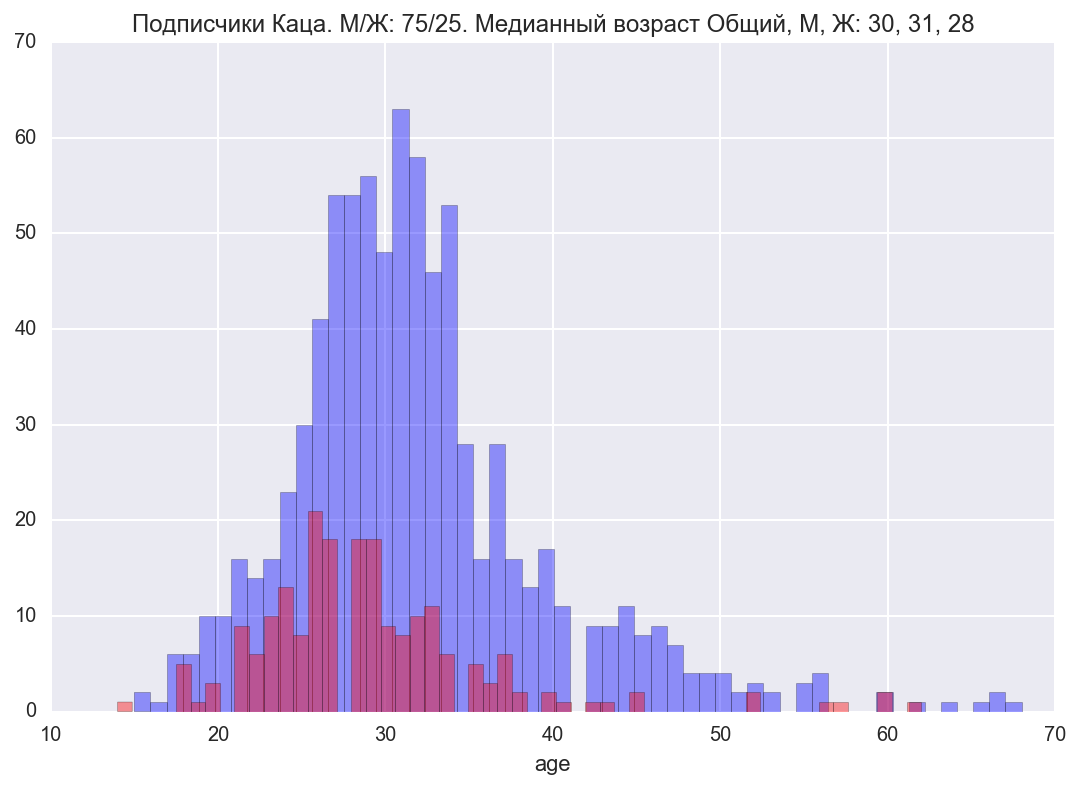

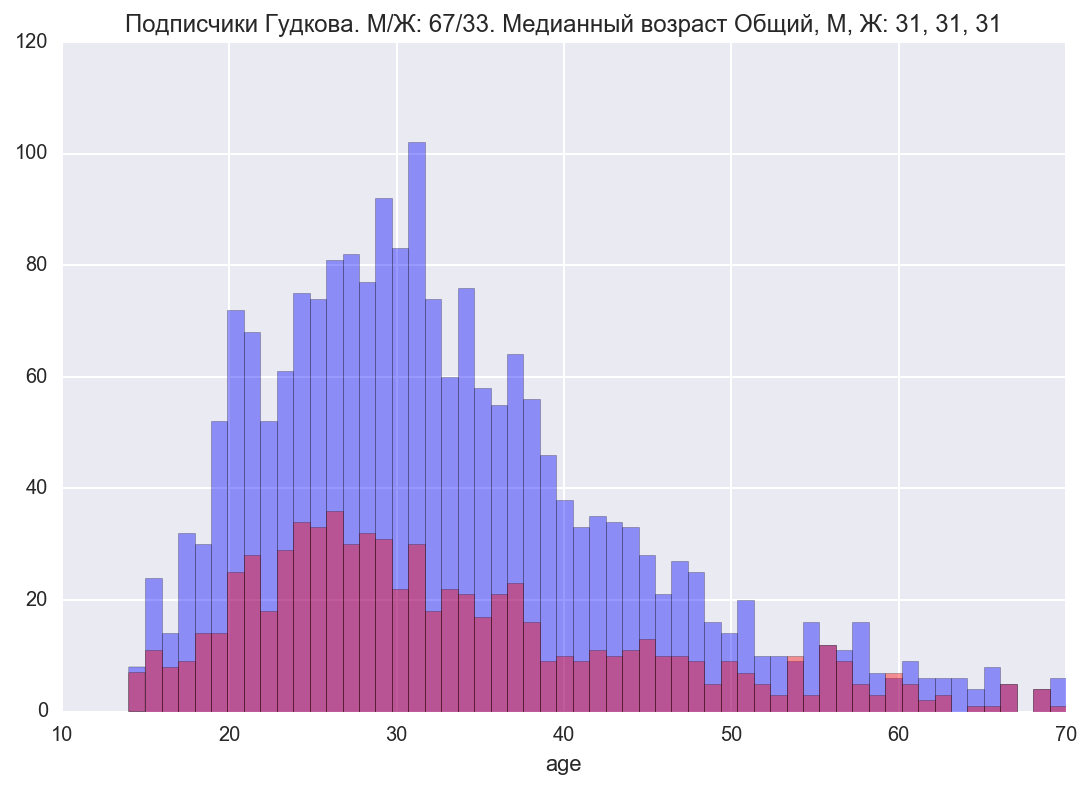

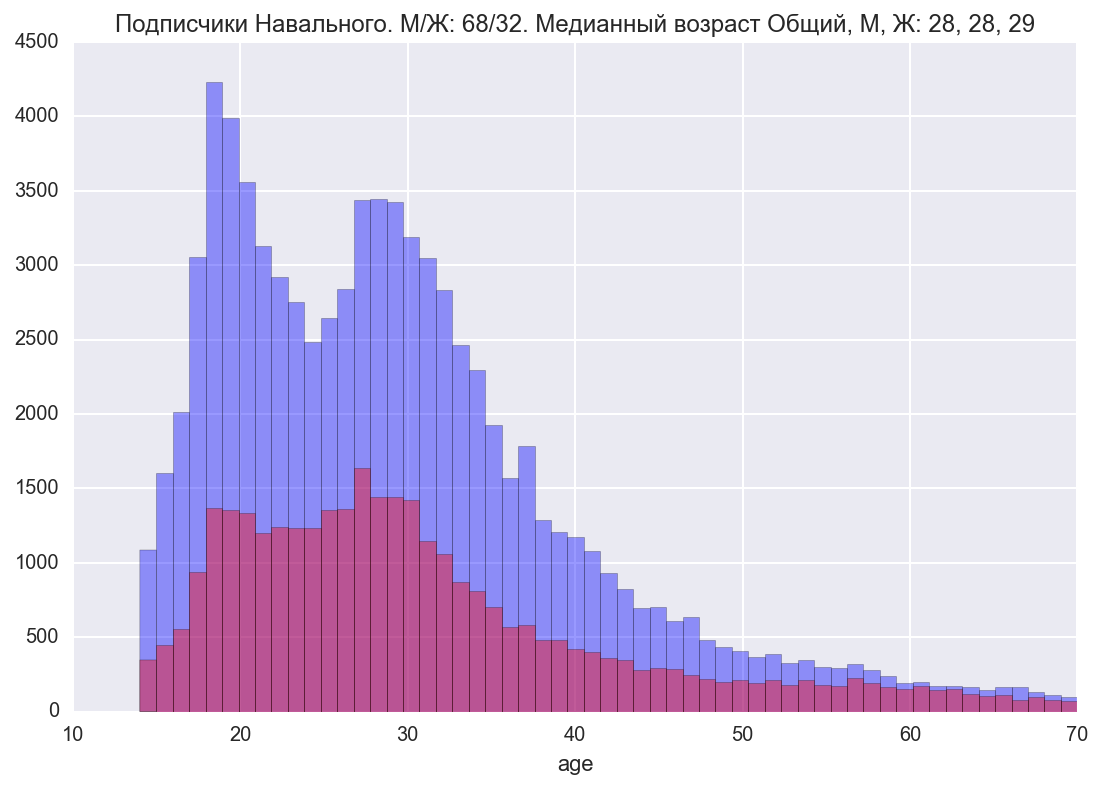

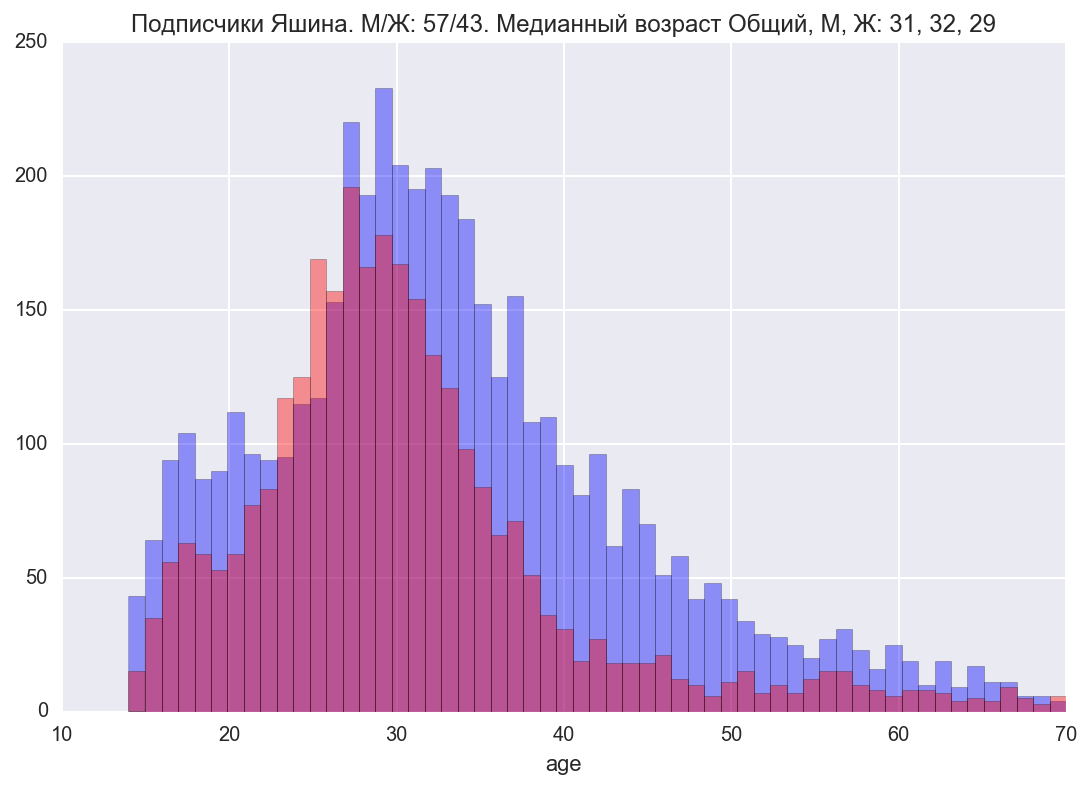

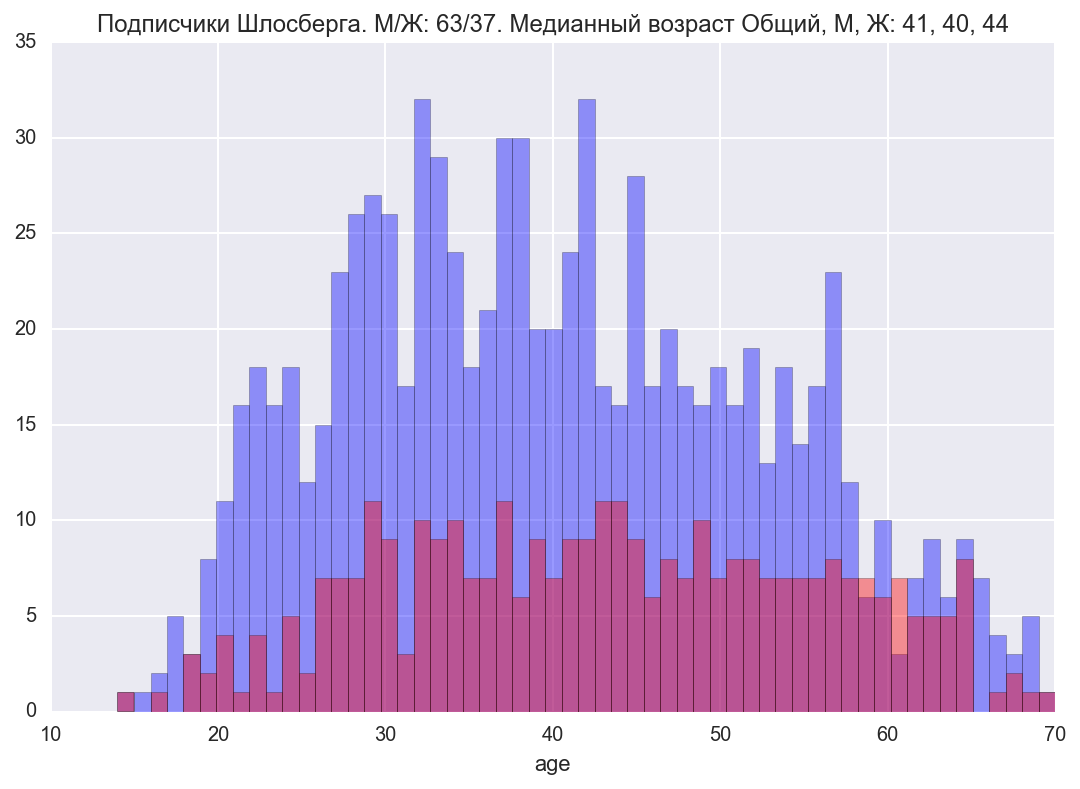

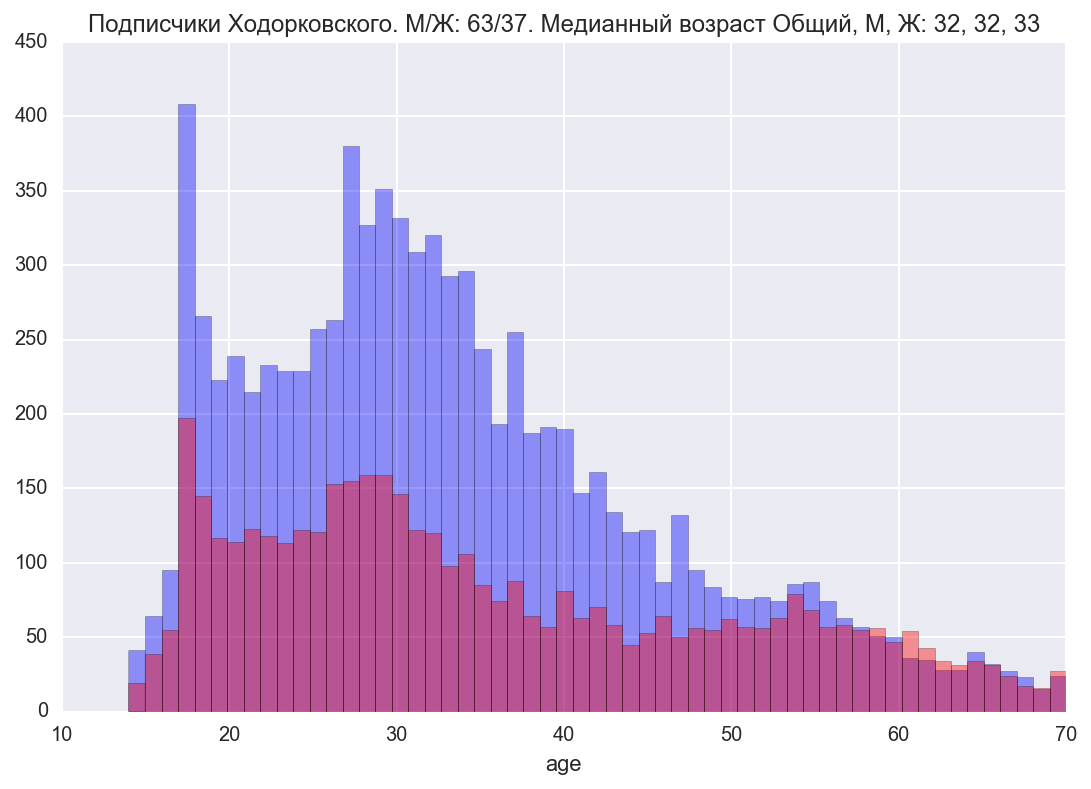

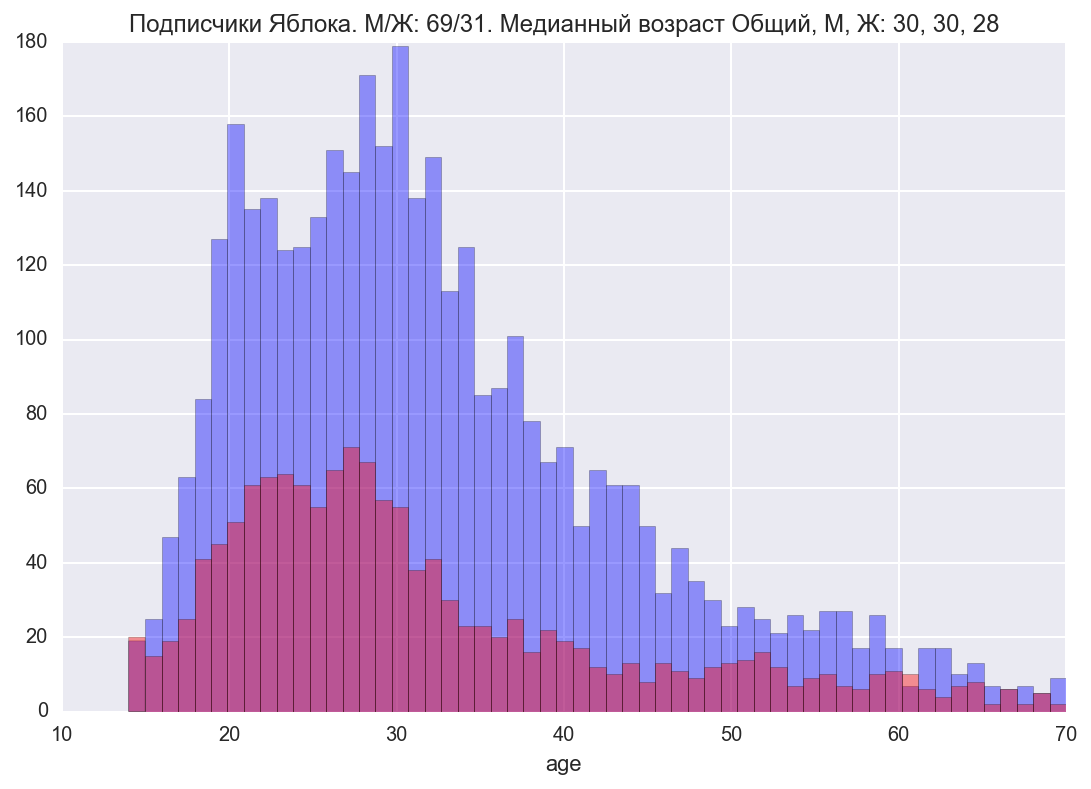

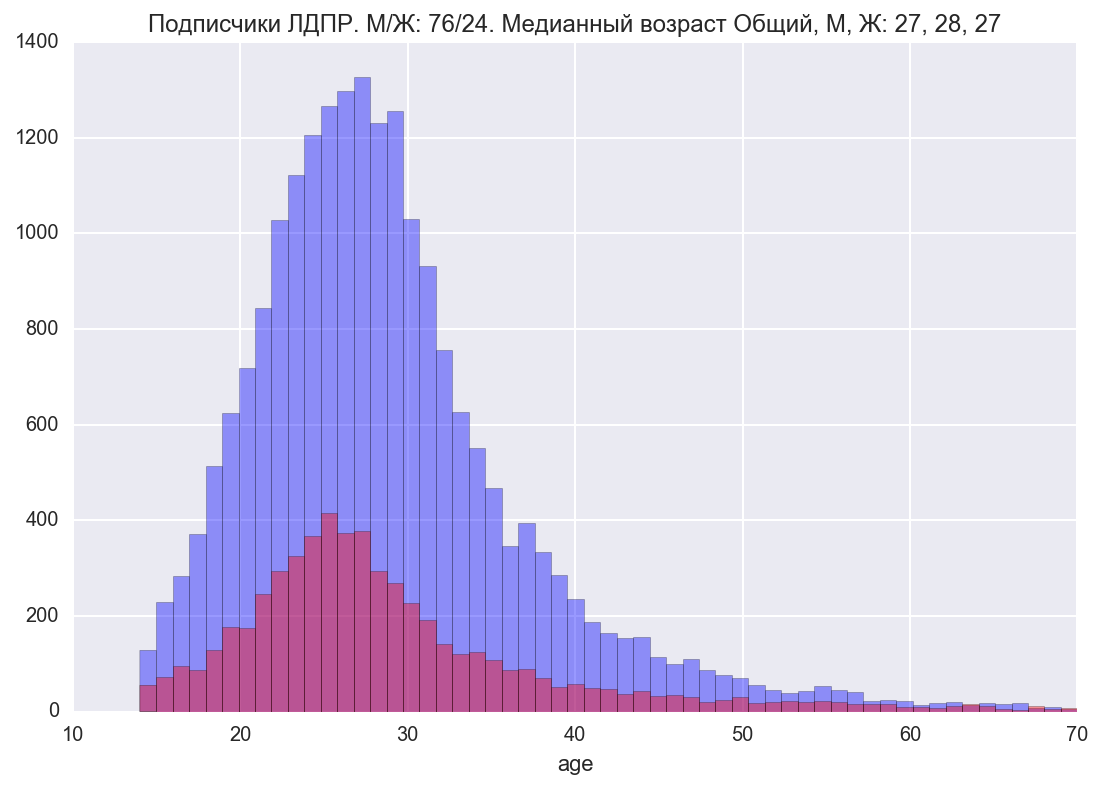

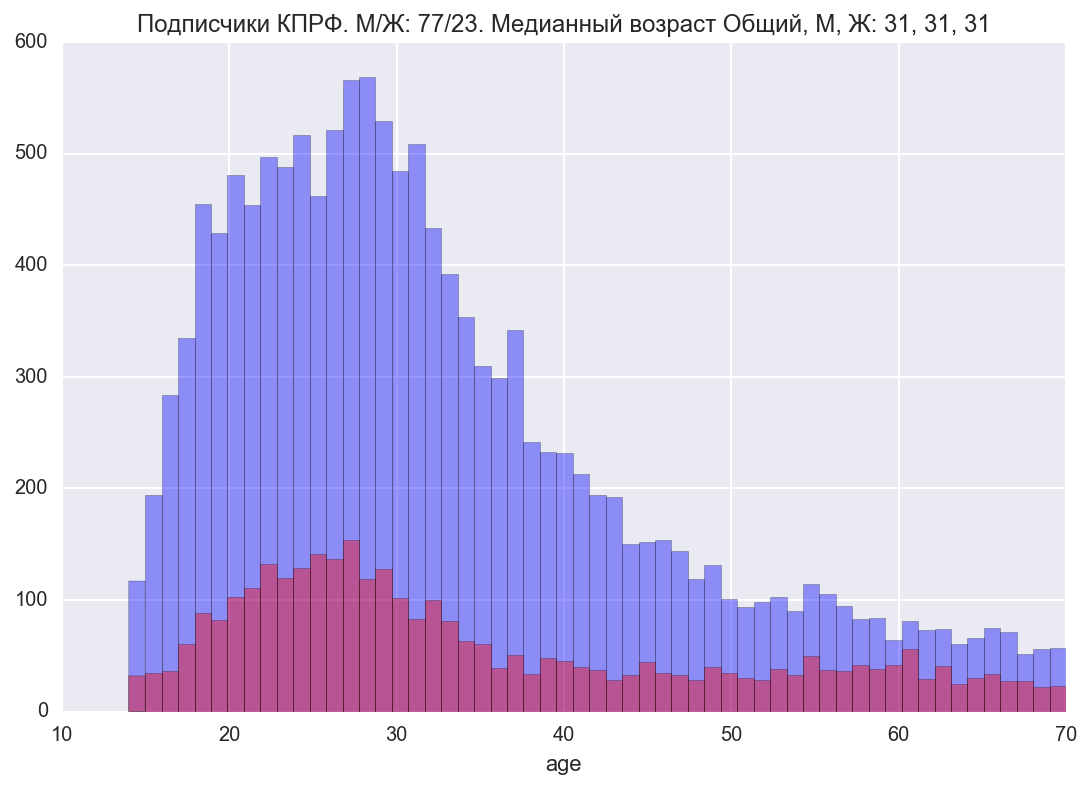

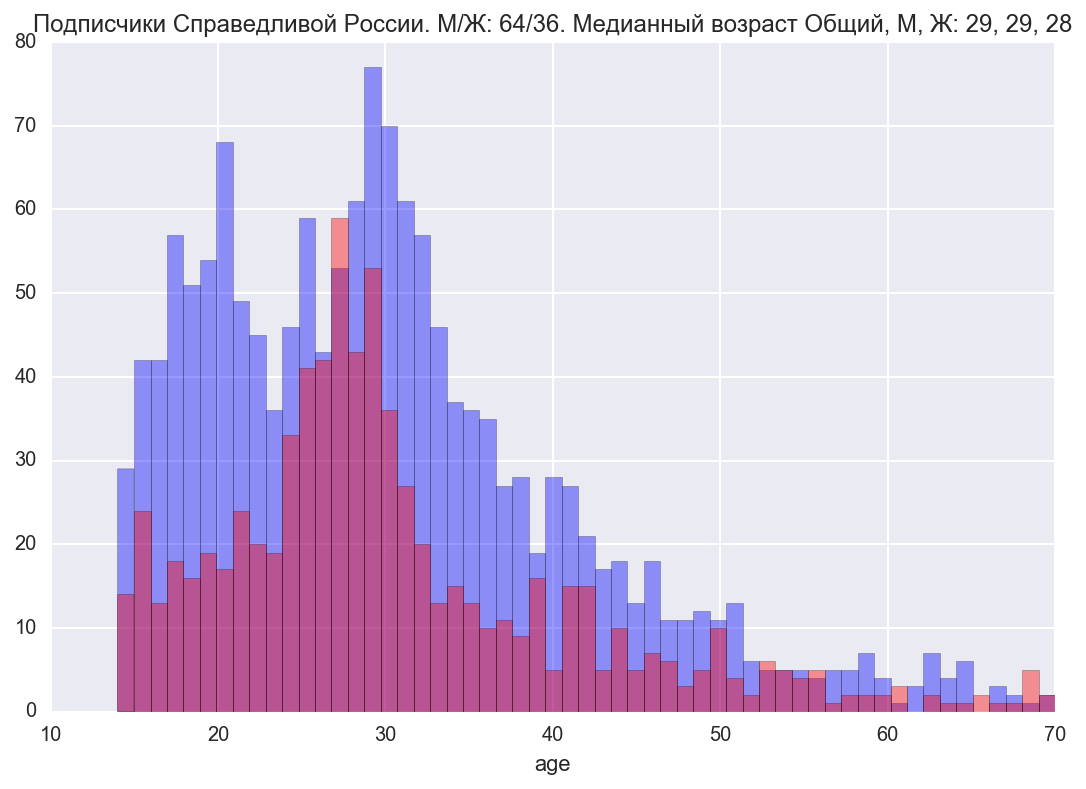

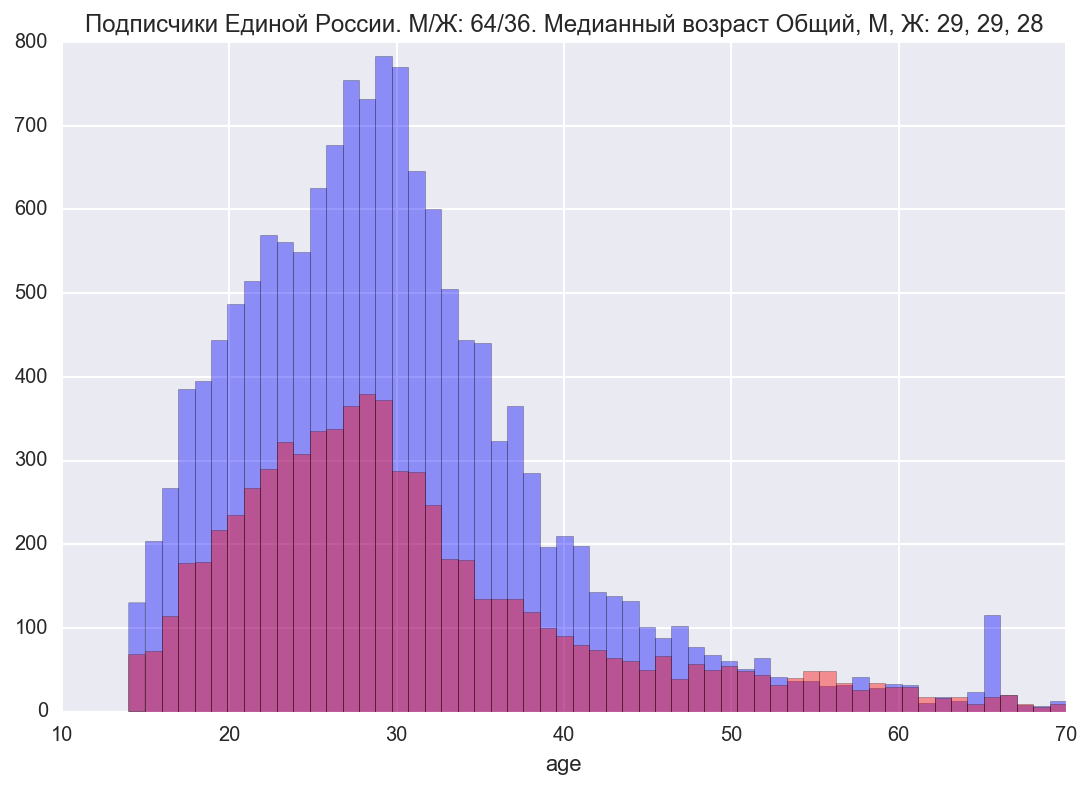

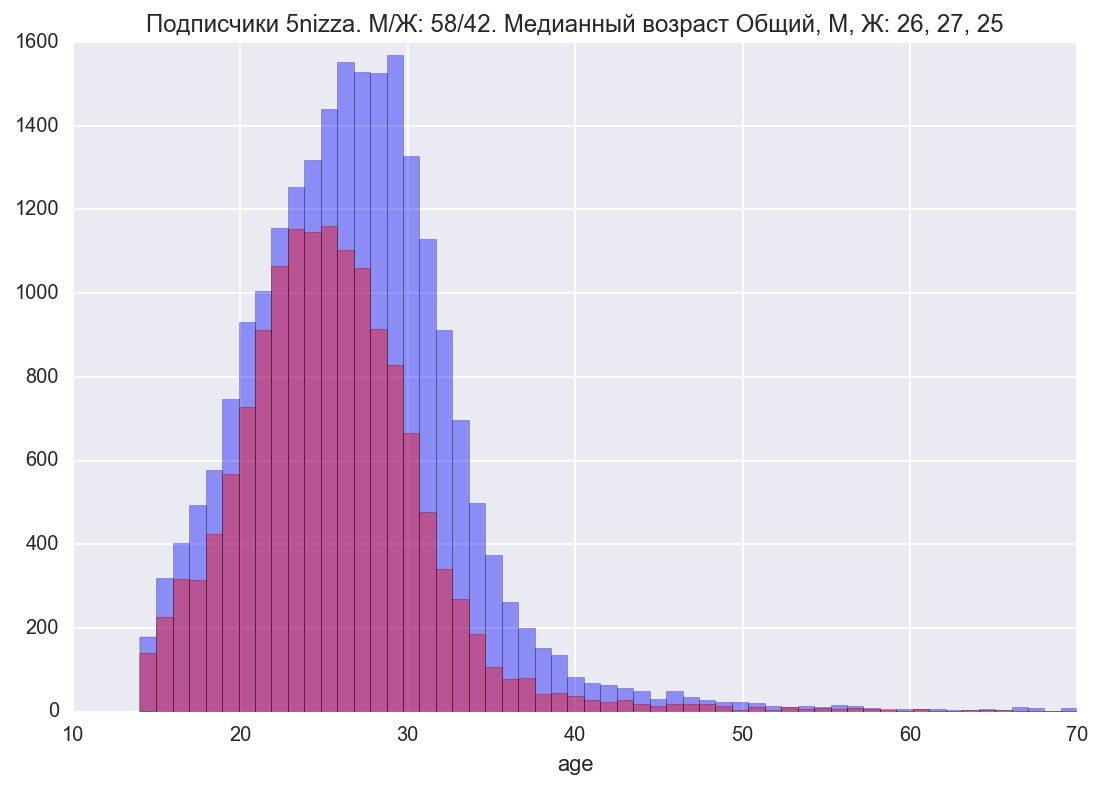

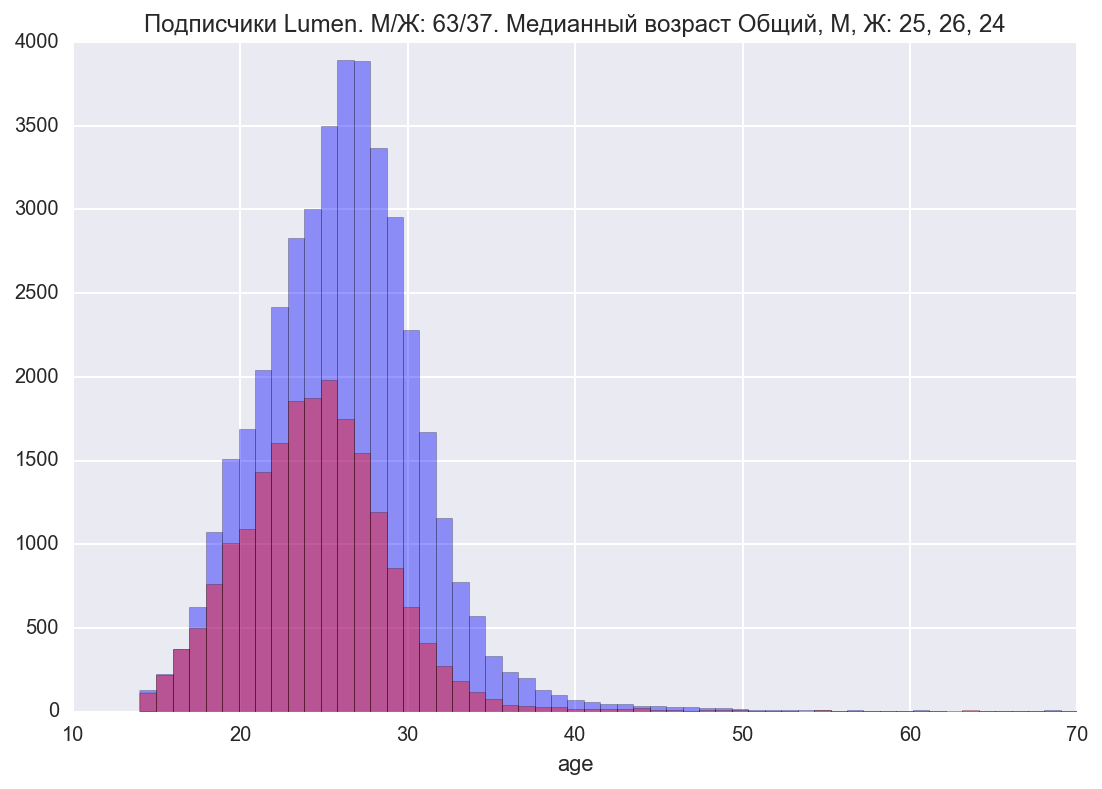

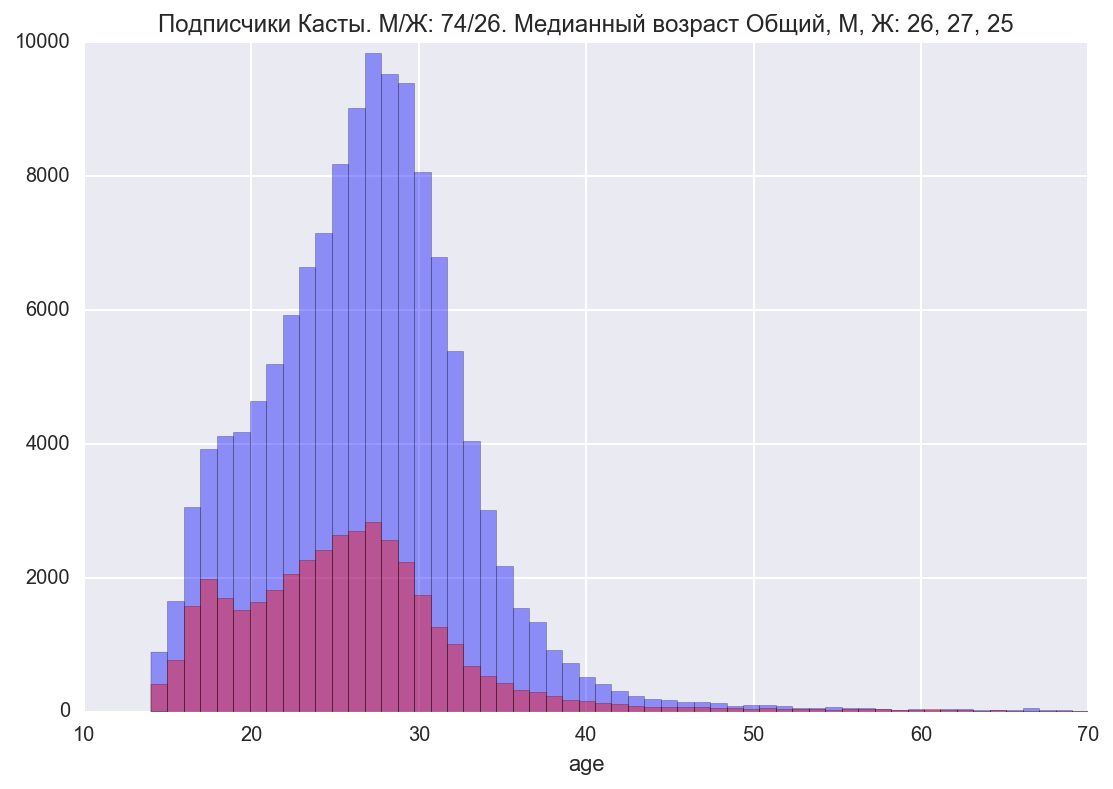

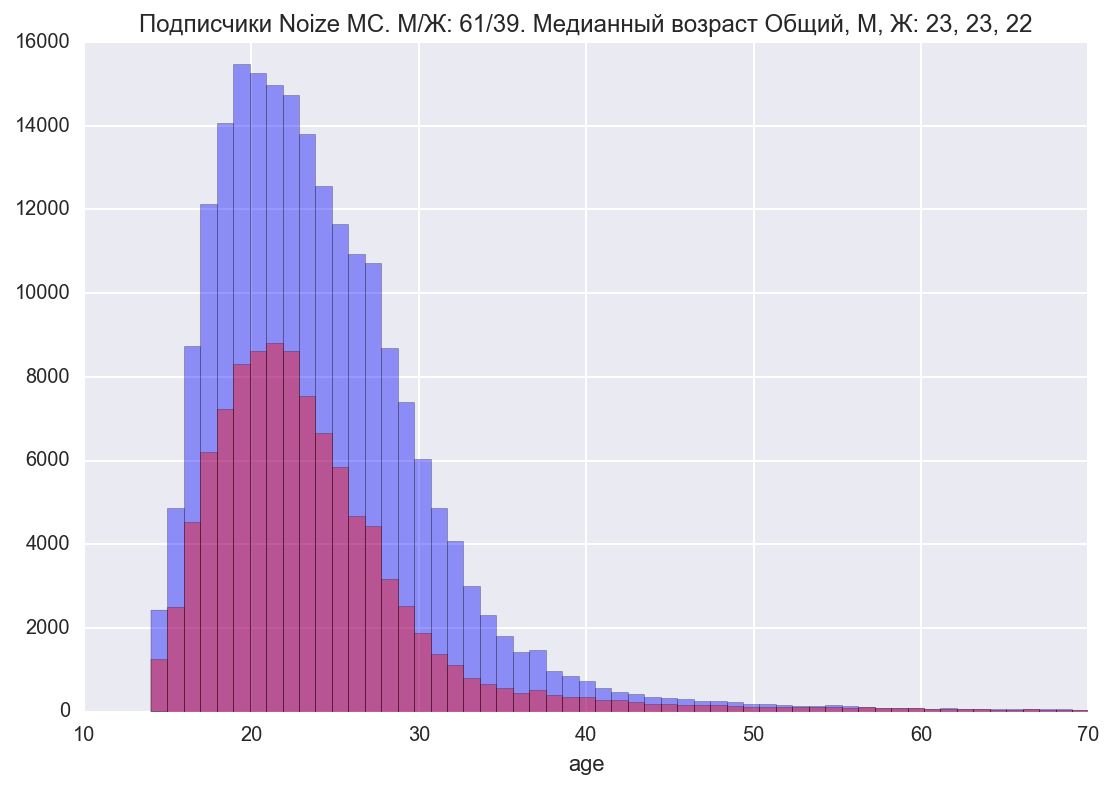

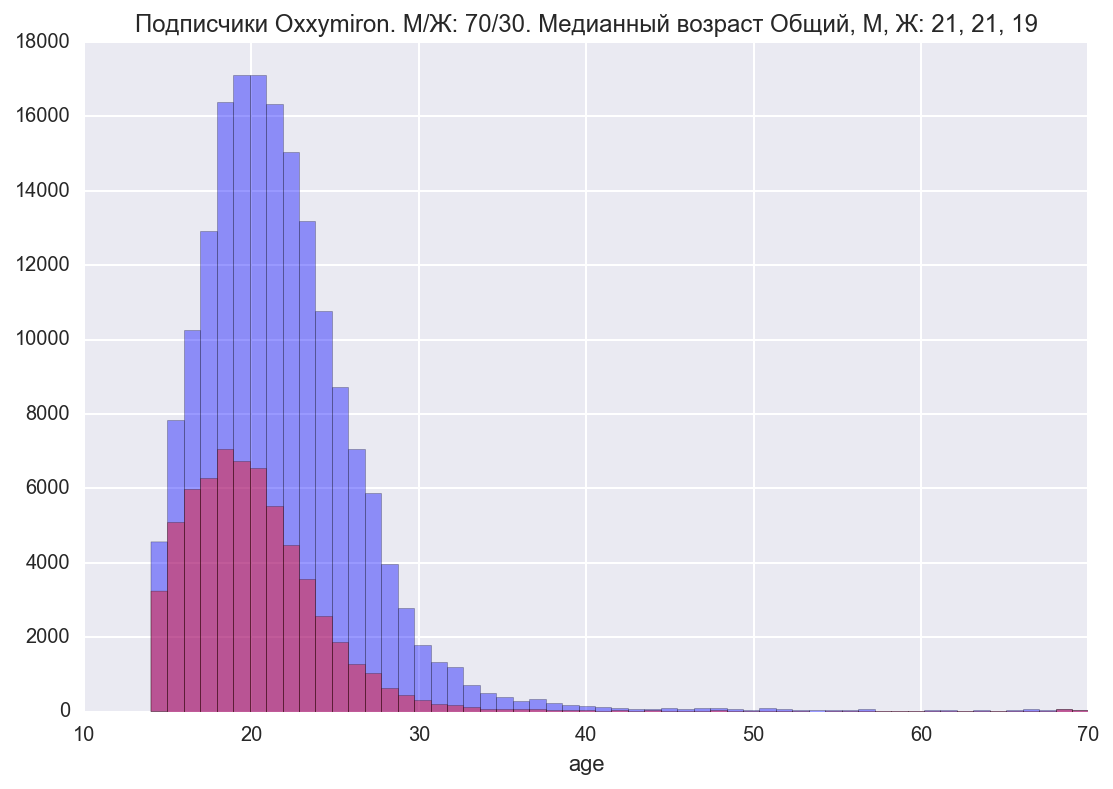

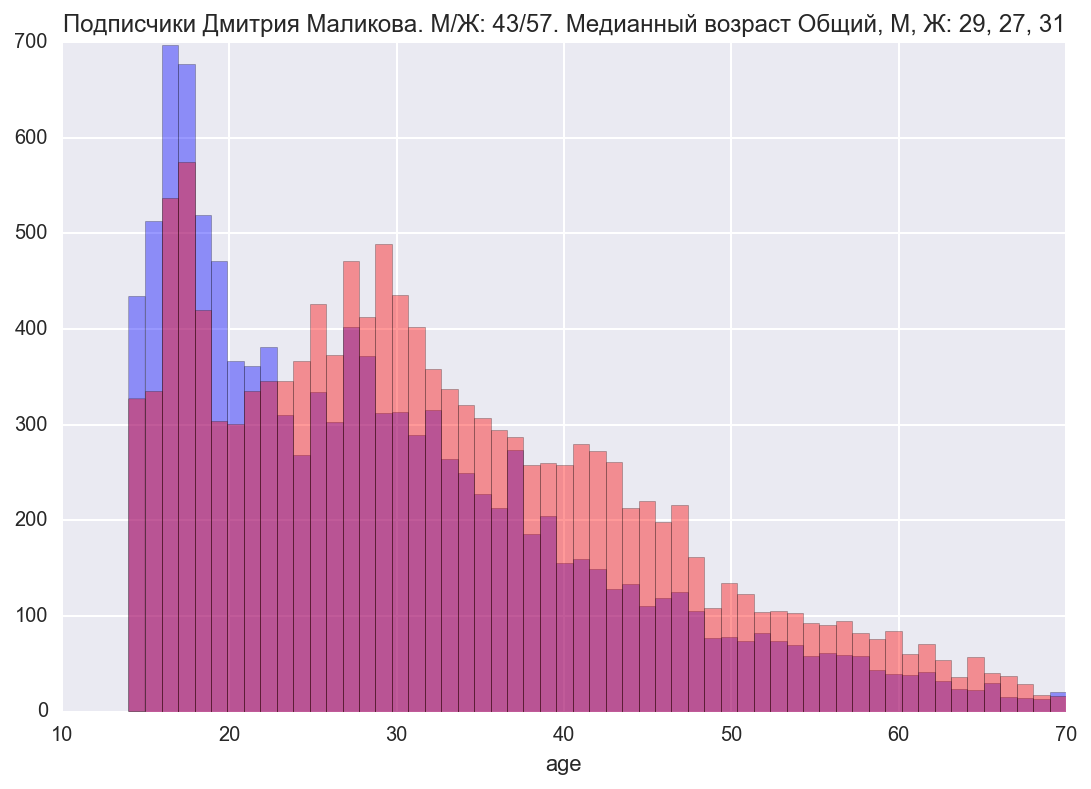

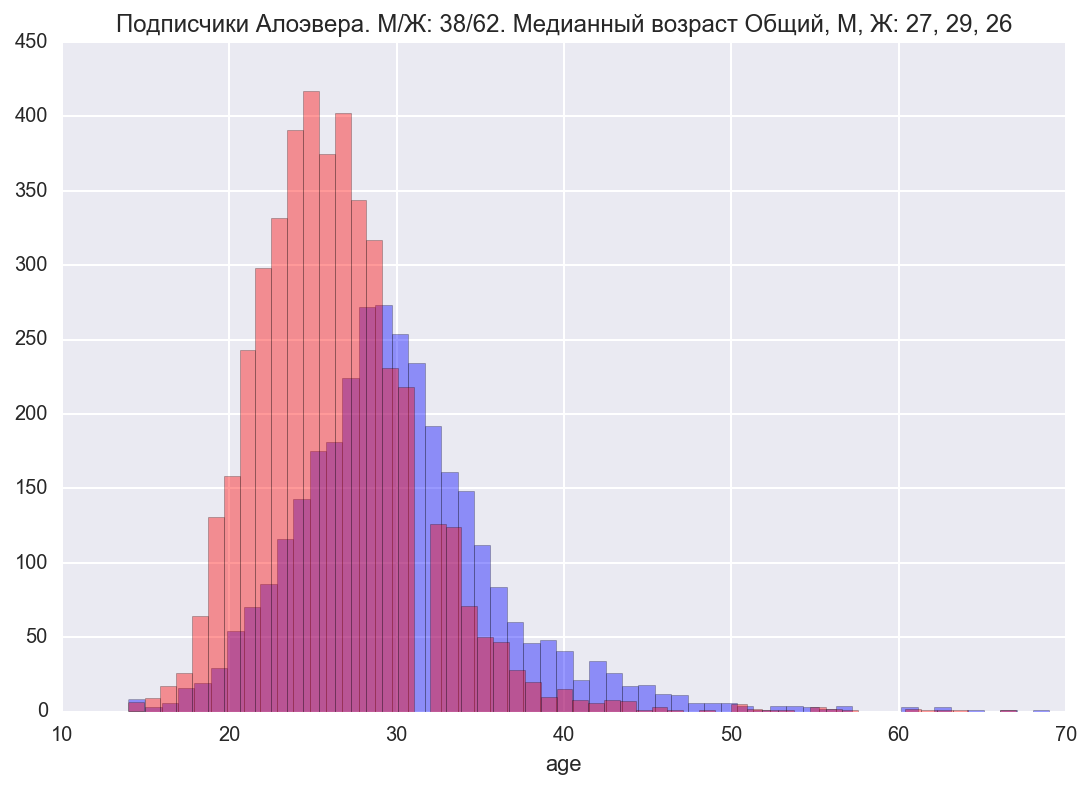

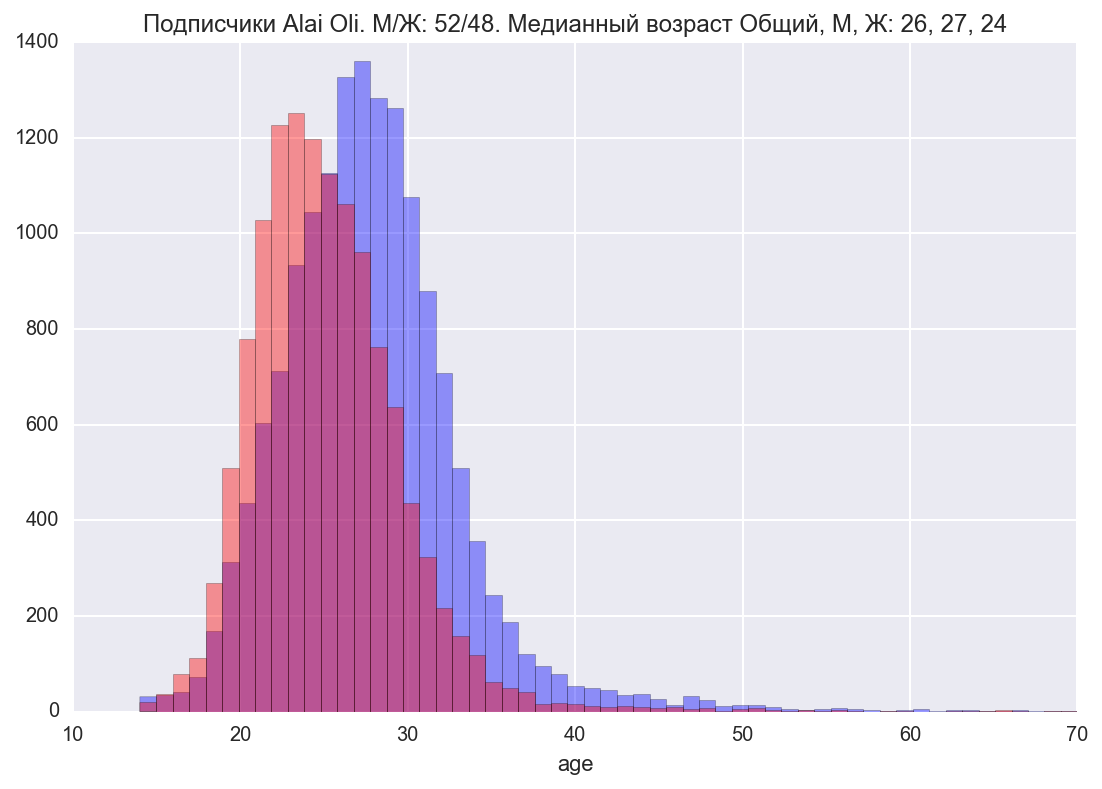

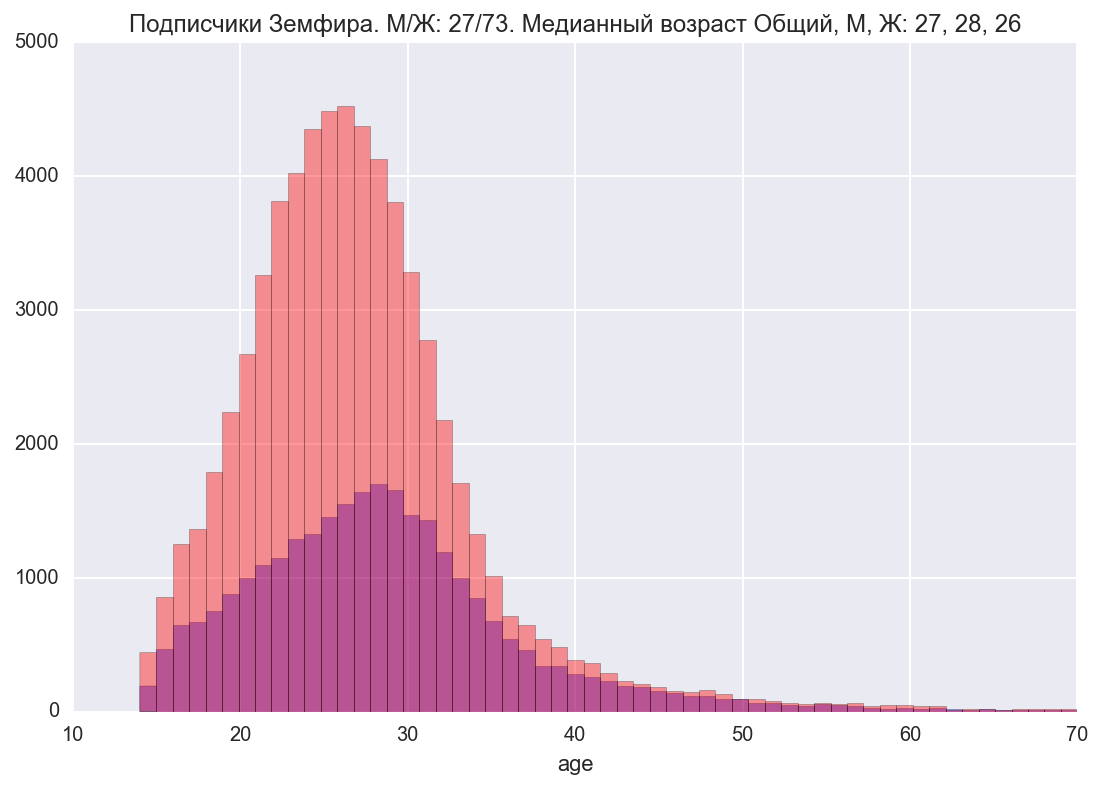

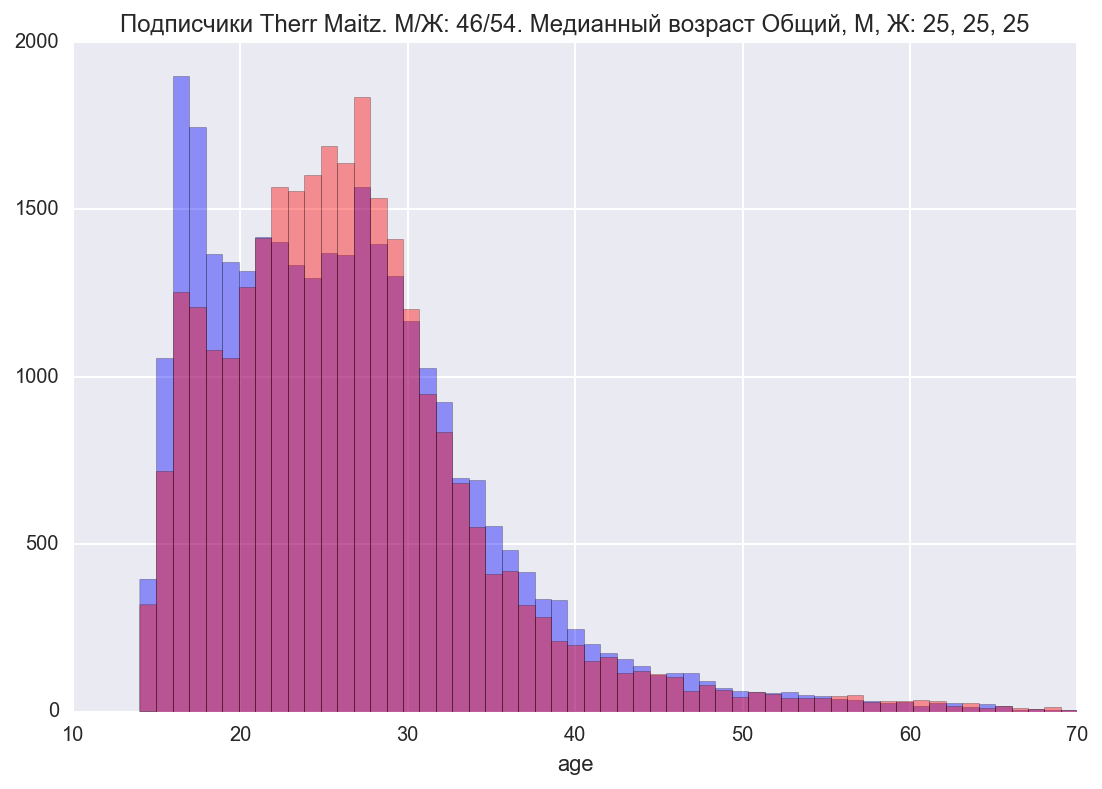

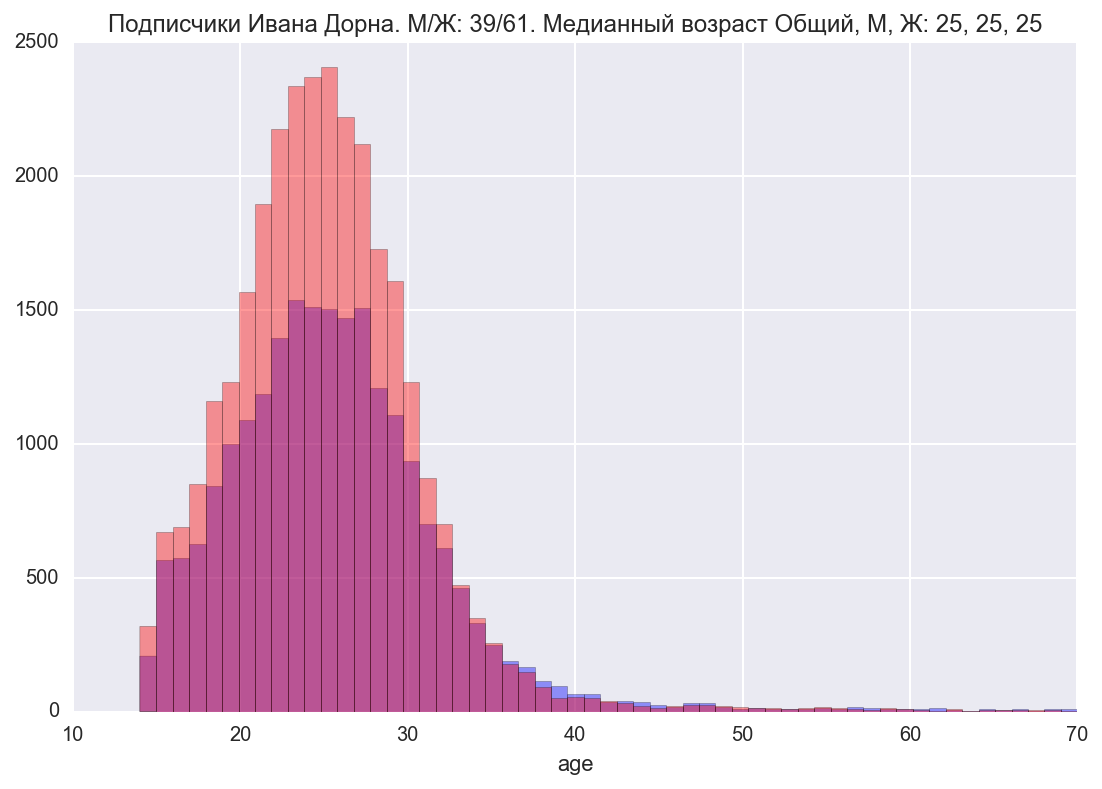

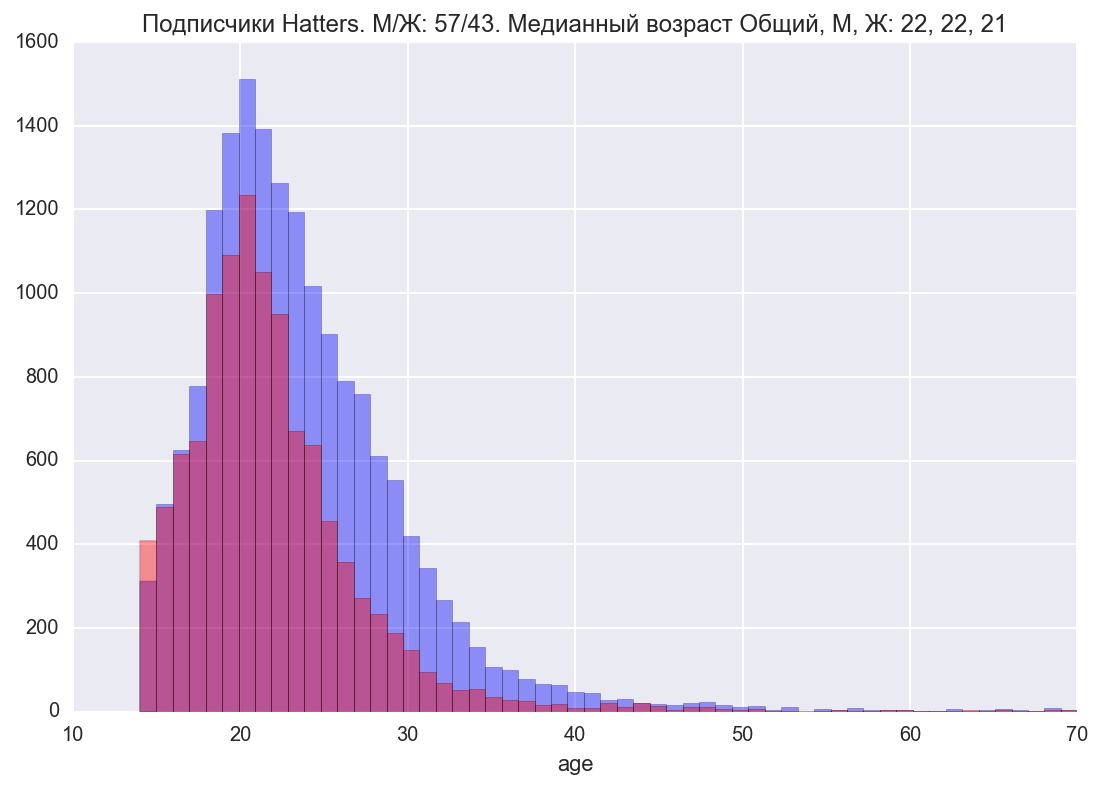

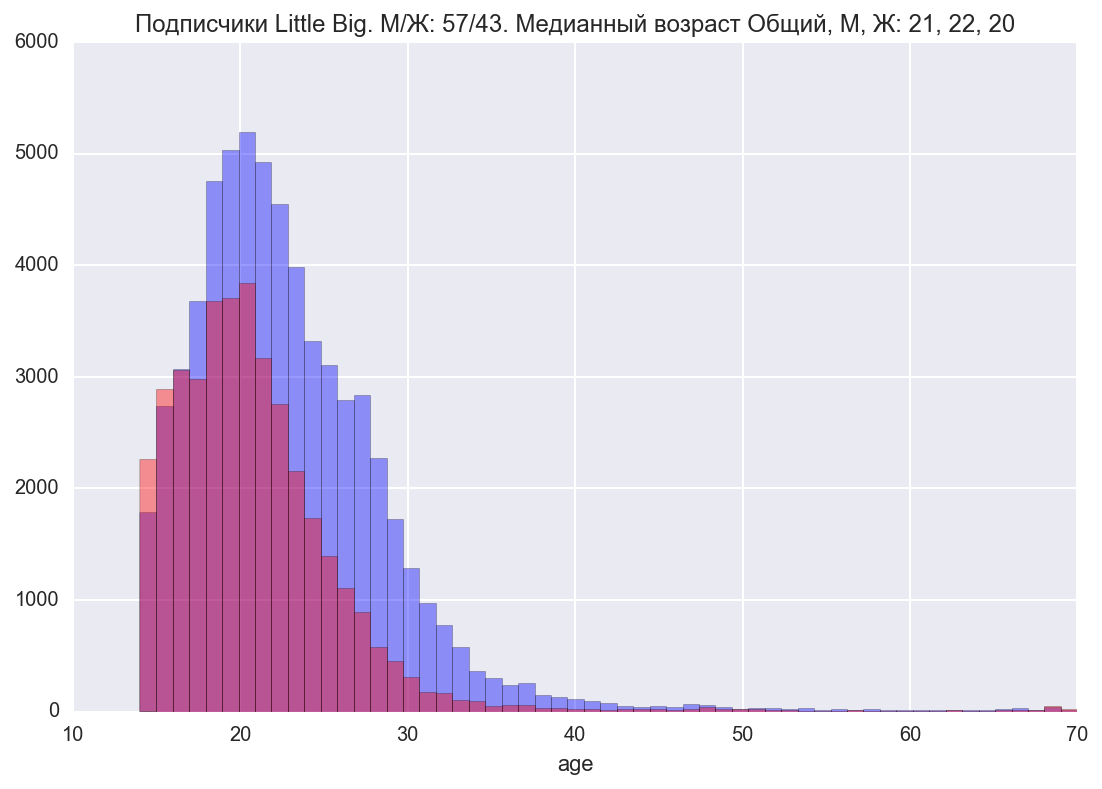

In [12]:
spec_parser(spec, folder)

In [13]:
rcParams['figure.figsize'] = (16, 9)

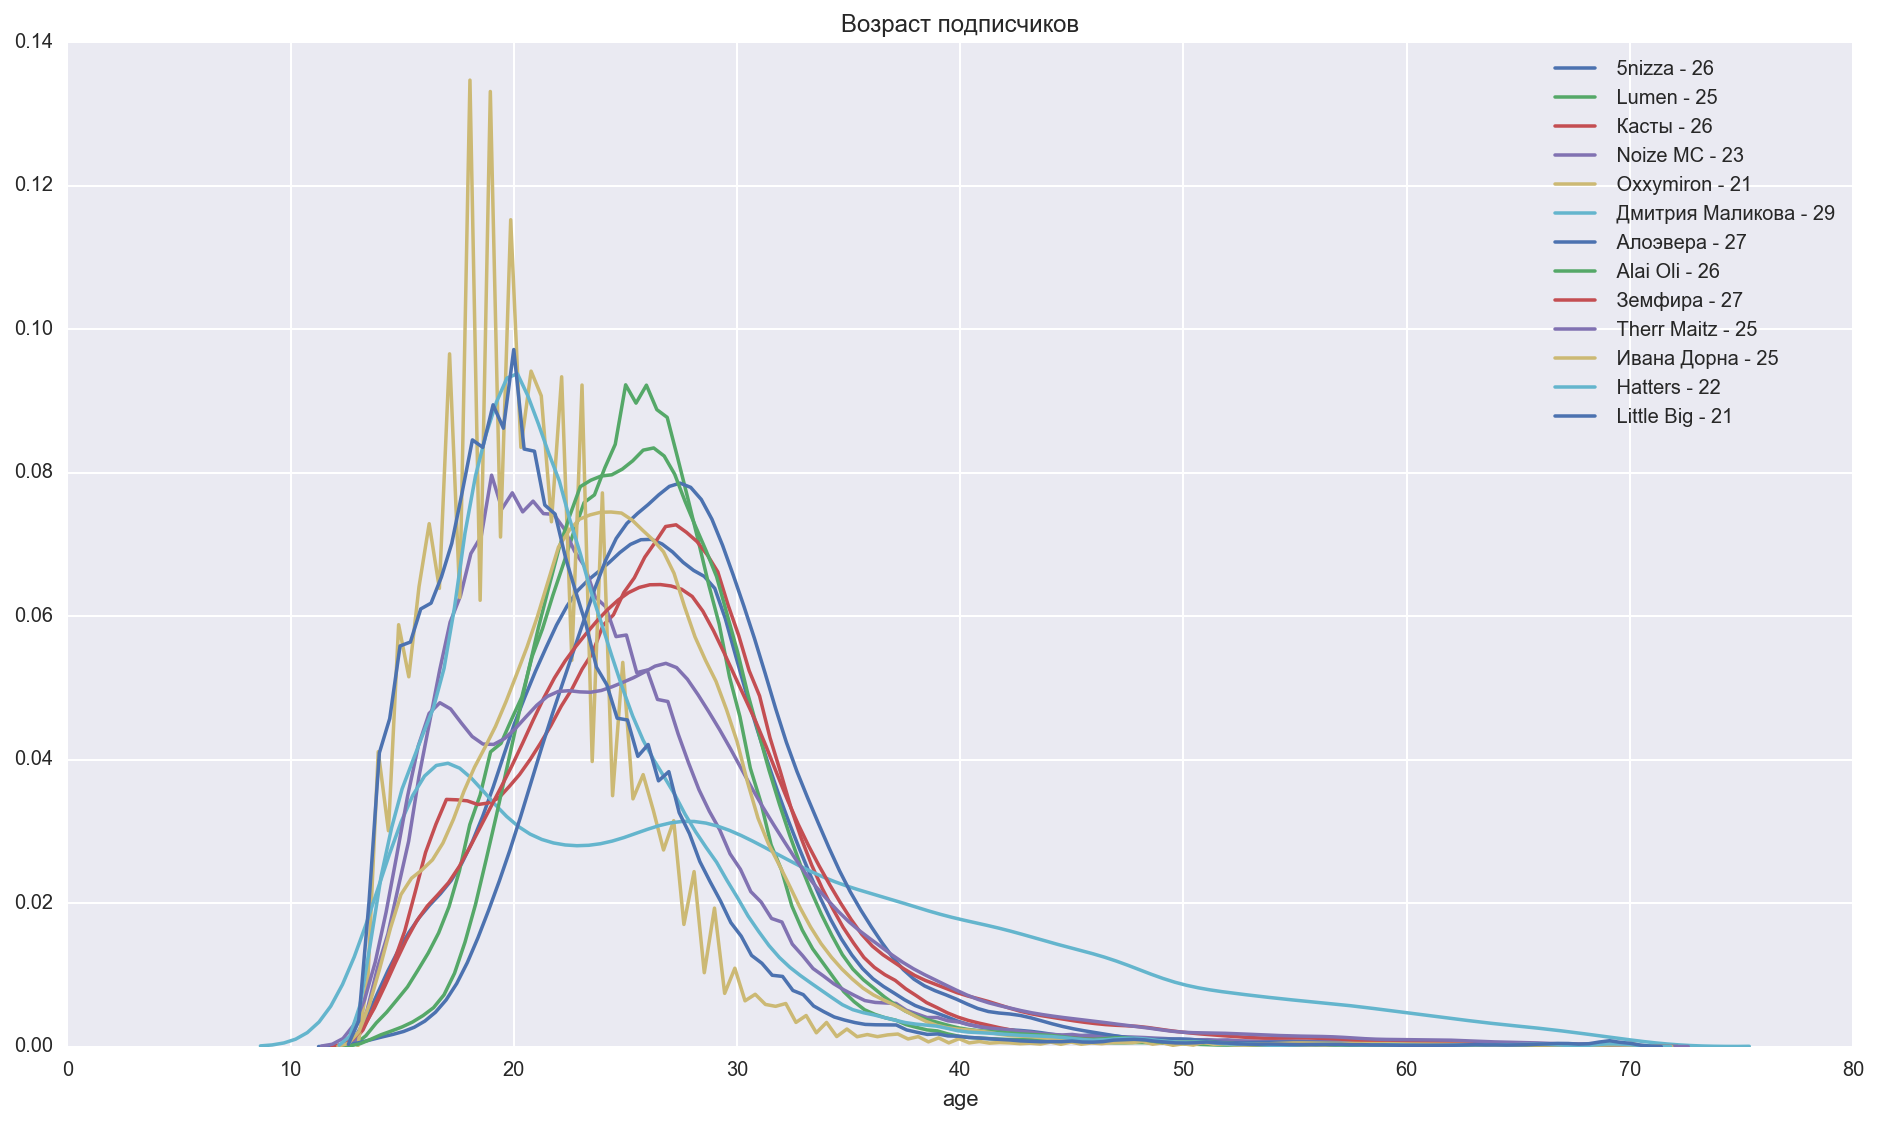

In [14]:
spec_parser.make_join_dist_plot([s for s in spec if s["topic"]=="music"], folder)

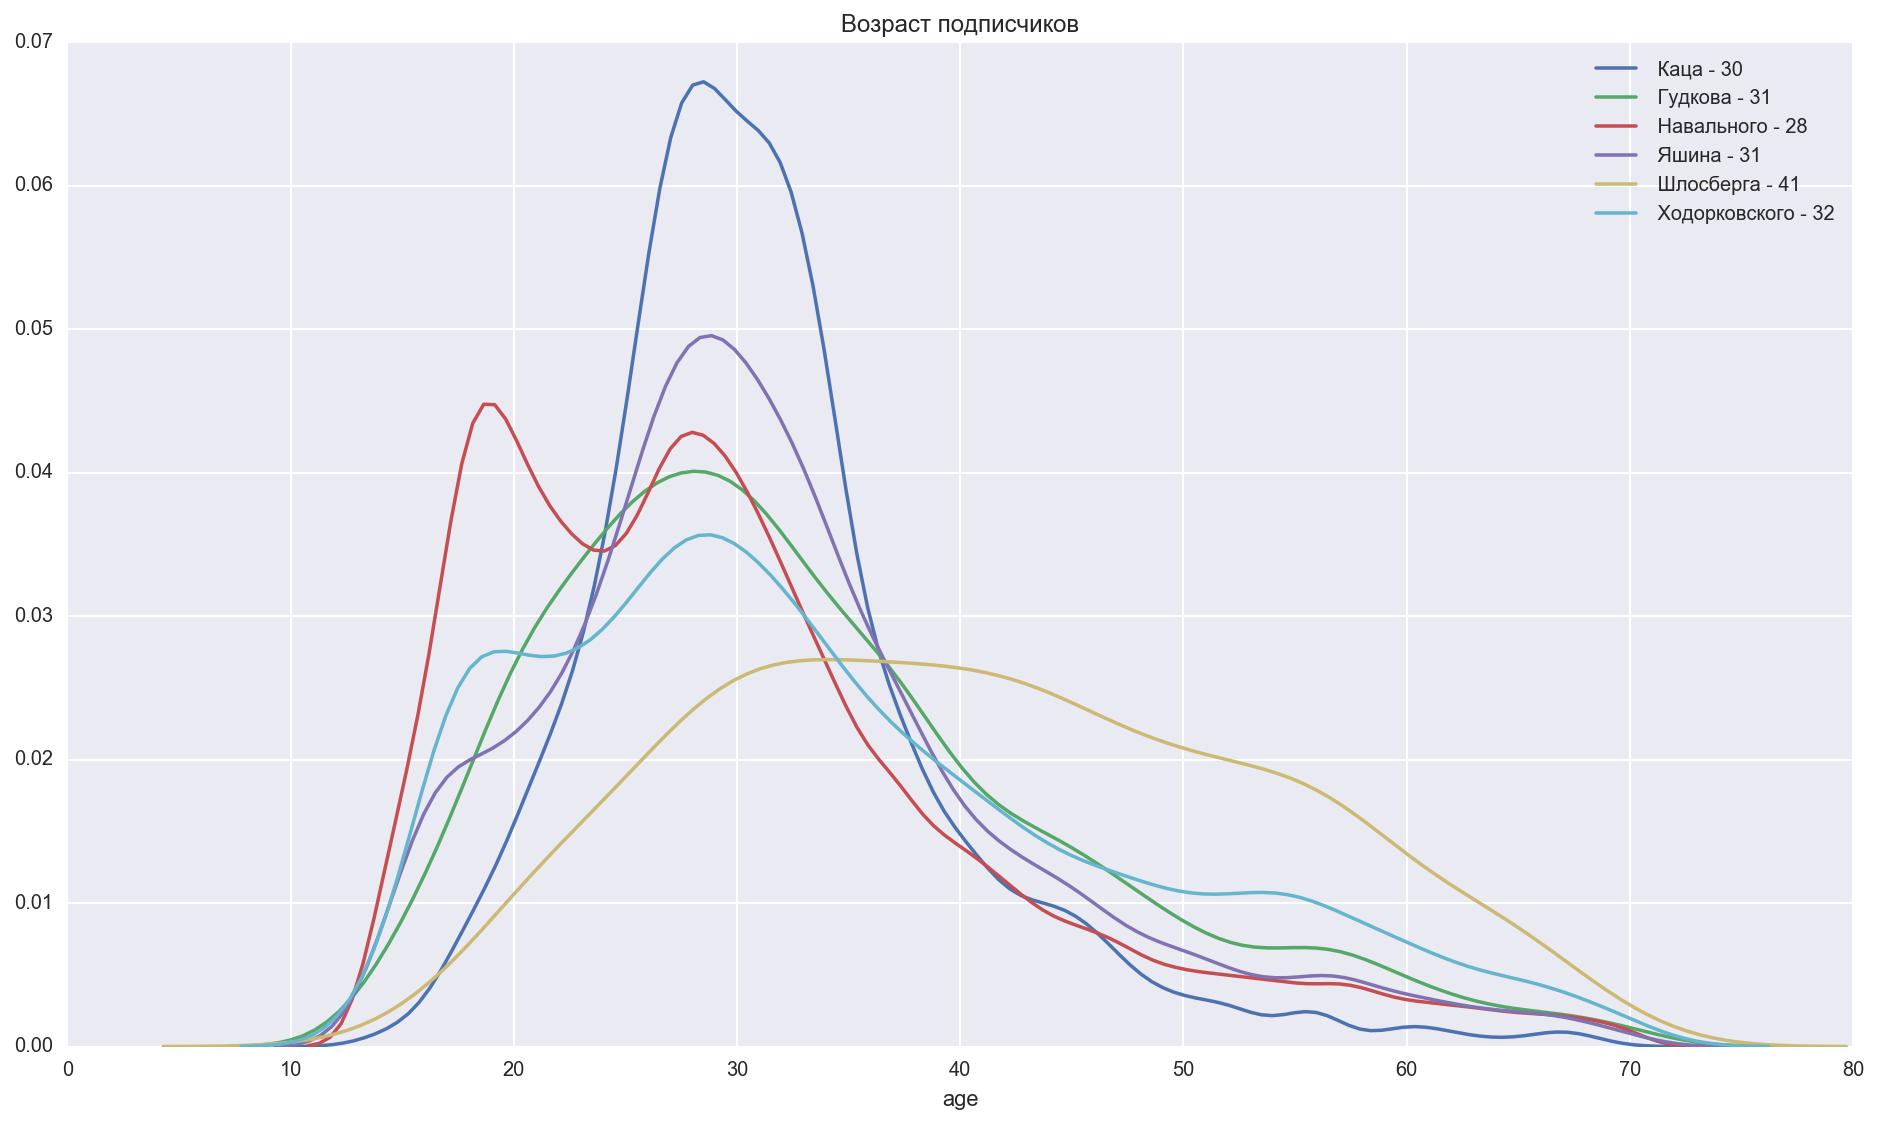

In [15]:
spec_parser.make_join_dist_plot([s for s in spec if s["topic"]=="politics"], folder)

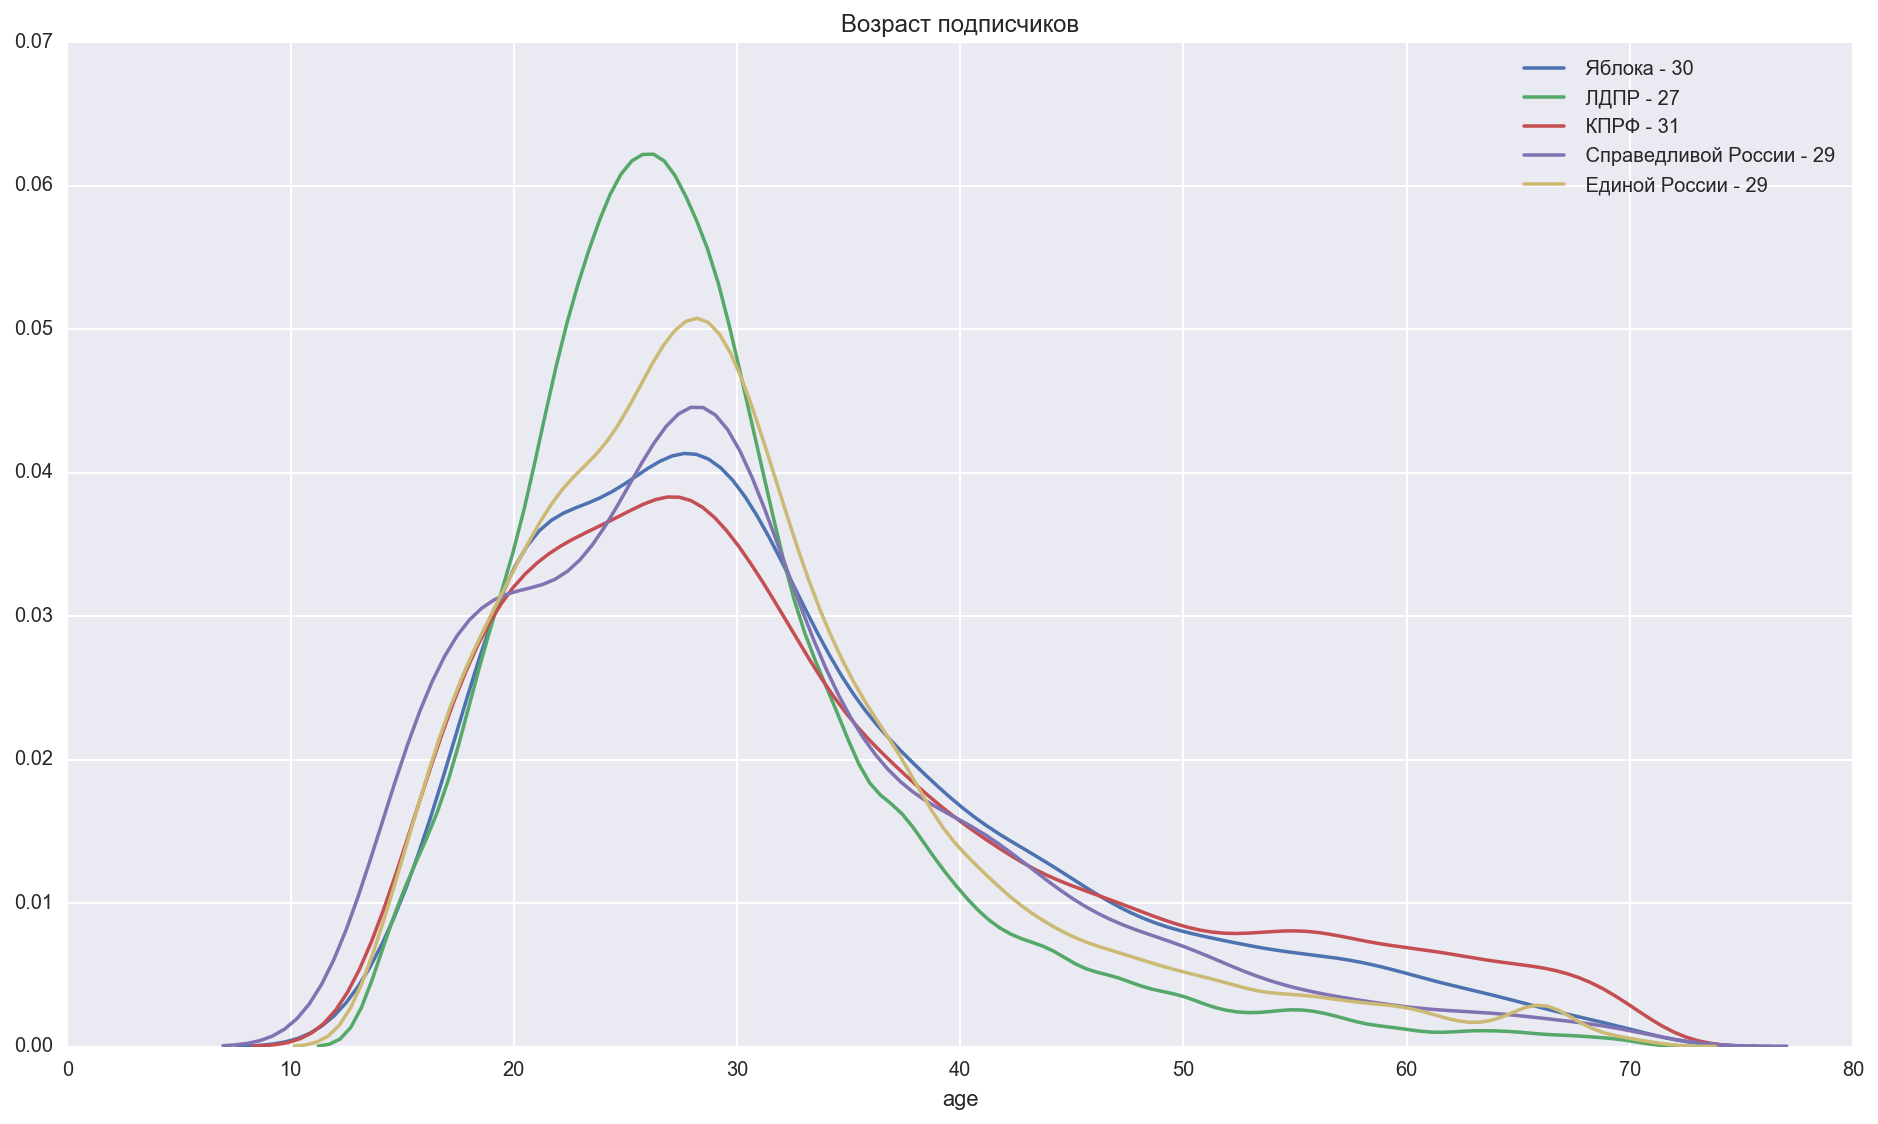

In [16]:
spec_parser.make_join_dist_plot([s for s in spec if s["topic"]=="political_party"], folder)